# **Deep learning Exam A.Y. 22/23**
# **D'Abramo Jacopo mat. 0001103441**


# Organization of the work



1.   Dataset
2.   Metrics
3.   Considerations
4.   Model
5.   Training
6.   Inference
7.   Conclusion  





# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence. 

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.

CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.


# 1) Dataset

The dataset is composed by a snapshot of wikipedia. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary. In addition, we restricted to sequences with a length between 3 and 30 words.

(Ignore the error, if any) 

In [ ]:
!pip install datasets
!pip3 install apache-beam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached dill-0.3.6-py3-none-any.whl (110 kB)
  Attempting uninstall: dill
    Found existing installation: dill 0.3.1.1
    Uninstalling dill-0.3.1.1:
      Successfully uninstalled dill-0.3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.48.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached dill-0.3.1.1-py3-none-any.whl
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.14 requires dill>=0.3.6, but you have dill 0.3.1.1 which is incompatible.


In [ ]:
from random import Random

# Instantiate the Random instance with random seed = 42 to ensure reproducibility
randomizer = Random(42)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
import numpy as np 
import pickle
import gdown
import random

In [ ]:
from datasets import load_dataset

dataset = load_dataset("wikipedia", "20220301.simple")

data = dataset['train'][:20000]['text']

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#run this cell only the first time to create and save the tokenizer and the date
dump = True

tokenizer = Tokenizer(split=' ', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', num_words=10000, oov_token='<unk>')

corpus = []

# Split of each piece of text into sentences
for elem in data:
  corpus += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus))

#add a start and an end token
corpus = ['<start> '+s+' <end>' for s in corpus]


# Tokenization	
tokenizer.fit_on_texts(corpus)

if dump:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

original_data = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen))]

if dump:
    with open('original.pickle', 'wb') as handle:
        pickle.dump(original_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("filtered sentences: ",len(original_data))

sos = tokenizer.word_index['<start>']
eos = tokenizer.word_index['<end>']

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

corpus dim:  510023
filtered sentences:  137301


We now create two additional datasets. 
* shuffled_data contains scrumbled sequences, and will be the input to the model. 
* target_data is the same as original data but offset by one timestep.
It is only useful if you plan to do some language modeling with a teacher forcing technique. You might decide to ignore it.


In [ ]:
shuffled_data = [random.sample(s[1:-1],len(s)-2) for s in original_data]
shuffled_data = [[sos]+s+[eos] for s in shuffled_data]
target_data = [s[1:] for s in original_data]

Let us look at some examples:

In [ ]:
i = np.random.randint(len(original_data))
print("original sentence: ",original_data[i])
print("shuffled sentecen: ",shuffled_data[i])

original sentence:  [2, 29, 7329, 4, 497, 186, 3]
shuffled sentecen:  [2, 186, 497, 29, 4, 7329, 3]


Let us look at detokenized data:

In [ ]:
i = np.random.randint(len(original_data))
print("original sentence: ",tokenizer.sequences_to_texts([original_data[i]])[0])
print("shuffled sentence: ",tokenizer.sequences_to_texts([shuffled_data[i]])[0])
print("Target sentence : ",tokenizer.sequences_to_texts([target_data[i]])[0])

original sentence:  <start> today there are many different sets of coins <end>
shuffled sentence:  <start> coins of sets there today many are different <end>
Target sentence :  today there are many different sets of coins <end>


## SPLIT AND AUGMENTATION
I reserved the 10% for the validation and I decided to apply data augmentation. In particular I've downloaded the whole version of wikipedia dataset (version 20220301.en) and applied the same pre-processing as the one already given. Moreover to avoid that in the augmented data there were some samples of the test set I further filtered it, eventually removing sentences of the test set.

In [ ]:
from sklearn.model_selection import train_test_split

y_train, y_test, c_train, c_test, _, _ = train_test_split(original_data, shuffled_data, target_data, test_size = 0.3, random_state = 42)

In [ ]:
c_train, c_val, y_train, y_val =  train_test_split(c_train, y_train, test_size = 0.1, random_state = 42)

In [ ]:
dataset = load_dataset("wikipedia", "20220301.en")

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
data_augmented = dataset['train'][:70000]['text']

corpus_aug = []
for elem in data_augmented:
  corpus_aug += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus_aug))

#add a start and an end token
corpus_aug = ['<start> '+s+' <end>' for s in corpus_aug]


augmented_data = [sen for sen in tokenizer.texts_to_sequences(corpus_aug) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen))]

corpus dim:  8437676


In [ ]:
augmented_data = list(set(map(tuple, augmented_data)).difference(set(map(tuple, y_test))))

In [ ]:
shuffled_aug = [random.sample(s[1:-1], len(s)-2) for s in augmented_data]
shuffled_aug = [[sos]+s+[eos] for s in shuffled_aug]

some prints of the augmented data

In [ ]:
for j in range(3):
  i = np.random.randint(len(augmented_data))
  print("original sentence: ",tokenizer.sequences_to_texts([augmented_data[i]])[0])
  print("shuffled sentecen: ",tokenizer.sequences_to_texts([shuffled_aug[i]])[0])
  print('\n')

original sentence:  <start> the anniversary edition of a classic study of black slave music in america <end>
shuffled sentecen:  <start> black in of the america anniversary study slave of classic music a edition <end>


original sentence:  <start> historically sometimes a father transmitted his combined family names thus creating a new one e <end>
shuffled sentecen:  <start> family a historically creating his one sometimes e father names new a thus transmitted combined <end>


original sentence:  <start> a player also receives an extra turn after a roll of 1 2 or of doubles <end>
shuffled sentecen:  <start> also 1 player doubles an of receives after or a a turn 2 extra of roll <end>




In [ ]:
# Concatenate with augmentation
c_train = np.concatenate([c_train, np.array(shuffled_aug, dtype=object)], axis = 0)
y_train = np.concatenate([y_train, np.array(augmented_data, dtype=object)], axis = 0)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
max_sequence_len = max([len(x) for x in original_data])

# Training Validation and Test data 
c_train = pad_sequences(c_train, maxlen=max_sequence_len, padding='post')
c_val = pad_sequences(c_val, maxlen=max_sequence_len, padding='post')
c_test = pad_sequences(c_test, maxlen=max_sequence_len, padding='post')

y_train = pad_sequences(y_train, maxlen=max_sequence_len, padding='post')
y_val = pad_sequences(y_val, maxlen=max_sequence_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_sequence_len, padding='post')

In [ ]:
print("train size:", len(c_train))
print("val size:", len(c_val))
print("test size:", len(c_test))

assert(len(c_train)==len(y_train))
assert(len(c_val)==len(y_val))
assert(len(c_test)==len(y_test))

train size: 800902
val size: 9611
test size: 41191


## DISTRIBUTION OF DATA



Let us finally have a look at the distribution of data w.r.t. their lenght.

(array([ 3897.,  5516.,  6180.,  7633., 10474., 11260., 11167., 10501.,
         9768.,  8942.,  7828.,  7010.,  6126.,  5236.,  4551.,  3922.,
         3260.,  2695.,  2306.,  1922.,  1611.,  1299.,  1126.,   827.,
          773.,   586.,   885.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30.]),
 <BarContainer object of 27 artists>)

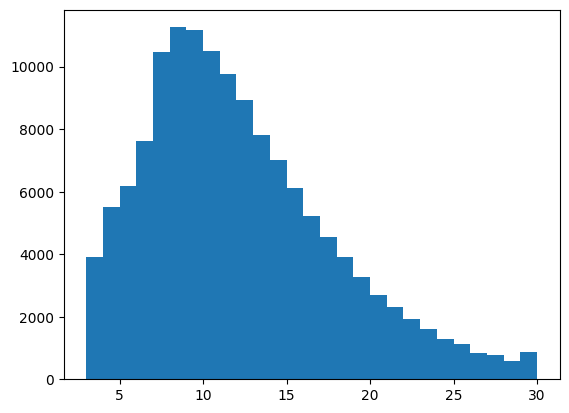

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(x)-2 for x in original_data],27)

# 2) Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/|s|

If the match is exact, the score is 1. 

When computing the score, you should NON consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [ ]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  return (match.size / max(len(p),len(s)))

Let's do an example.

In [ ]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ", score(original, generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# 3) Some considerations concerning the task
The solve this task I've implemented different models and this notebook will report the one with the best score obtained. In particular I started implementing sequence to sequence models such as RNN,LSTM and the results obtained were around 0.45 and 0.49. After it I've choosen to implement a transformer knowing the great success they have had in NLP tasks. Unlike RNNs or convolutional neural networks, Transformers are able to capture distant or long-range contexts and dependencies in the data between distant positions in the input or output sequences. Thus, longer connections can be learned. Attention allows each location to have access to the entire input at each layer, while in RNNs and CNNs, the information needs to pass through many processing steps to move a long distance, which makes it harder to learn.

The transformer I decided to implement are:
  - FNet: which uses Fast Fourier transformer to improve the speed of the attention mechanism 
  - the one reported in the paper "Attention is all you need"

After several experiments I found that the second one in general performed better.

# 4) Model
The technique employed here is referred to as "teacher forcing" since, irrespective of the model's output at every step, it receives the correct value as input for the subsequent step. This method of training a text generation model is both straightforward and effective. Its efficiency stems from the fact that the model can compute the outputs at various sequence positions simultaneously, eliminating the need for sequential processing.

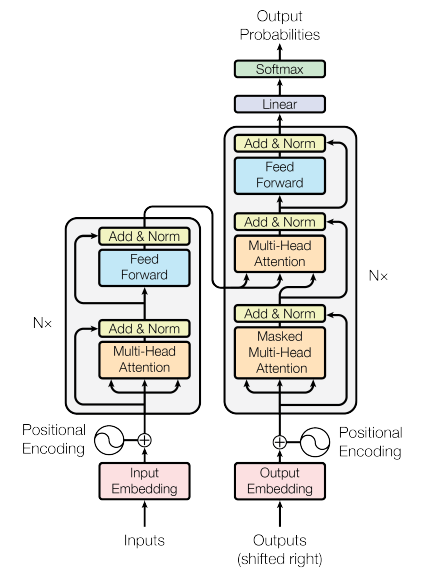

In [145]:
import tensorflow as tf
from tensorflow.keras.callbacks import  LearningRateScheduler, EarlyStopping,ReduceLROnPlateau
import time

In [146]:
BATCH_SIZE = 256

In [147]:
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((c_train, y_train))
    .batch(BATCH_SIZE))

val_raw = (
    tf.data.Dataset
    .from_tensor_slices((c_val, y_val))
    .batch(512))

In [148]:
def process_text(context, target):
    targ_in = target[:,:-1]
    targ_out = target[:,1:]
    return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [149]:
UNITS = 64
VOCAB_SIZE = 10000
SENTENCE_LENGTH = 32

## Pos embedding layer

In [150]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / ((10000**depths))         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=32, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

## Attention layers

In [151]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [152]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [153]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [154]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [155]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [156]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [157]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

## Encoder

In [158]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

## Decoder

In [159]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

## Transformer

In [160]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(10000)

  def call(self, inputs):
    context, x  = inputs
    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits


  def predict(self, x, *args, **kwargs):
      encoder_input = x

      max_length = 32

      batch_size = encoder_input.shape[0]
      output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)

      start = np.array(tokenizer.word_index['<start>'], ndmin=1)
      output_array = output_array.write(0, tf.tile(start, [batch_size]))

      for i in tf.range(max_length-1):
        output = tf.transpose(output_array.stack())
        predictions = self([encoder_input, output], training=False)

        # Select the last token from the seq_len dimension.
        predictions = predictions[:, -1:, :]  # Shape (batch_size, 1, vocab_size).

        predicted_id = tf.argmax(predictions, axis=-1)

        # Concatenate the predicted_id to the output which is given to the
        # decoder as its input.
        output_array = output_array.write(i+1, predicted_id[:, 0])
        
        end_mask = tf.reduce_any(tf.equal(predicted_id, tokenizer.word_index['<start>']), axis=-1)
        if tf.reduce_all(end_mask):
              break

      output = tf.transpose(output_array.stack())
      self([encoder_input, output[:,:-1]], training=False)
      
      return output

  def evaluate(self, x, y, *args, **kwargs):
      res = super().evaluate(x, y, *args, **kwargs)
      batches = 3
      acc = 0
      for (input, _), y in x.take(batches):
 
          out_tokens = self.predict(input)
          out_tokens = out_tokens[:, 1:]
          
          label = tf.cast(y, out_tokens.dtype)
          matches = label == out_tokens

          mask = label != 0  

          matches = matches & mask

          matches = tf.cast(matches, dtype=tf.float32)
          mask = tf.cast(mask, dtype=tf.float32)
          
          acc += ((tf.reduce_sum(matches))/tf.reduce_sum(mask))  # BATCH_SIZE
      acc /= batches
      res['acc'] = tf.cast(acc, tf.float32)
      return res

In [161]:
num_layers = 4
d_model = 128
dff = 500
num_heads = 19
dropout_rate = 0.1


transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=VOCAB_SIZE,
    target_vocab_size=VOCAB_SIZE,
    dropout_rate=dropout_rate)

for (c,x),y in train_ds.take(1):
  break

output = transformer((c,x))
transformer.summary()

Model: "transformer_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_5 (Encoder)         multiple                  6806992   
                                                                 
 decoder_5 (Decoder)         multiple                  11818448  
                                                                 
 dense_101 (Dense)           multiple                  1290000   
                                                                 
Total params: 19,915,440
Trainable params: 19,915,440
Non-trainable params: 0
_________________________________________________________________


# 5) Training

In [162]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [163]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.AdamW(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9, weight_decay = 0.005)

In [164]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [165]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    )

In [166]:
history = transformer.fit(train_ds,
                epochs=35,
                validation_data=val_ds
                ) 

Epoch 1/35
3129/3129 [==============================] - 429s 126ms/step - loss: 4.0827 - val_loss: 1.7532 - val_acc: 0.2936
Epoch 2/35
3129/3129 [==============================] - 337s 108ms/step - loss: 1.4751 - val_loss: 1.1169 - val_acc: 0.3261
Epoch 3/35
3129/3129 [==============================] - 339s 108ms/step - loss: 1.0811 - val_loss: 0.9202 - val_acc: 0.3408
Epoch 4/35
3129/3129 [==============================] - 336s 107ms/step - loss: 0.9240 - val_loss: 0.8322 - val_acc: 0.3583
Epoch 5/35
3129/3129 [==============================] - 338s 108ms/step - loss: 0.8381 - val_loss: 0.7826 - val_acc: 0.3701
Epoch 6/35
3129/3129 [==============================] - 338s 108ms/step - loss: 0.7736 - val_loss: 0.7473 - val_acc: 0.3745
Epoch 7/35
3129/3129 [==============================] - 336s 107ms/step - loss: 0.7267 - val_loss: 0.7194 - val_acc: 0.3892
Epoch 8/35
3129/3129 [==============================] - 336s 107ms/step - loss: 0.6905 - val_loss: 0.7065 - val_acc: 0.3867
Epoch 9/

# 6) Inference

## Utilities functions

In [ ]:
# takes a sentence and format it for the evaluation
def tokens_to_text(tokens): 
    result = tf.strings.regex_replace(tokens, '<[^>]+>','')
    result = tf.strings.regex_replace(result, ' +', ' ')  # Normalize multiple spaces to a single space
    result = tf.strings.strip(result)
    return result

In [ ]:
# converts the sentence of y_test
def conversion(token_list):
    exclude_nums = [2, 3, 0]
    words = [tokenizer.index_word[token] for token in token_list if token not in exclude_nums]
    text = ' '.join(words)
    return text

In [ ]:
# find biggest substring in common
def common(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  matched_string = "|" + s[match.a: match.a + match.size] + "|"
  return matched_string

In [ ]:
# evaluation function
def evaluate(y_test, results):
    i = 0
    scores = []
    for j in range(len(results)):
        for k in range(len(results[j])):
            scores.append(score(
                results[j][k].numpy().decode("utf-8"),conversion(y_test[i])
            ))
            i = i + 1
    return np.mean(scores)

## Predict 
the inference process a batch in parallel, it predicts token by token

In [ ]:
class Predict(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer
    self.start = tokenizers.word_index['<start>']
    self.end = tokenizers.word_index['<end>']

  def __call__(self,test):
    predictions = []
    total_iter = tf.shape(test)[0] // BATCH_SIZE
    res = []
    st_idx = end_idx = 0 
    for i in range(total_iter):
         start_time = time.time()
         st_idx = i*BATCH_SIZE
         end_idx = i*BATCH_SIZE + BATCH_SIZE
         batch_data = test[st_idx:end_idx] 
         results = self.predict(batch_data)
         end_time = time.time()
         total_time = end_time - start_time
         print(f"total time for {i}-th iterations [{st_idx},{end_idx}]= {round(total_time,2)} seconds")
         start_time = time.time()
         batch_sentences = tokens_to_text(results)
         res.append(batch_sentences)

    print(f"total time for {i}-th iterations [{end_idx},to end]= {round(total_time,2)} seconds")
    batch_data = test[end_idx:] 
    results = self.predict(batch_data)
    batch_sentences = tokens_to_text(results)
    res.append(batch_sentences)
    return res

  def predict(self, encoder_input, max_length=32):
    
    batch_size = encoder_input.shape[0]
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)

    start = np.array(self.start, ndmin=1)
    output_array = output_array.write(0, tf.tile(start, [batch_size]))

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the seq_len dimension.
      predictions = predictions[:, -1:, :]  # Shape (batch_size, 1, vocab_size).

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the predicted_id to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[:, 0])
      
      end_mask = tf.reduce_any(tf.equal(predicted_id, self.end), axis=-1)
      if tf.reduce_all(end_mask):
            break

    output = tf.transpose(output_array.stack())
    tokens_list = output.numpy().tolist()
    sentence = [tokenizer.sequences_to_texts([row])[0] for row in tokens_list]

    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return sentence

In [167]:
pred = Predict(tokenizer, transformer)

## Test

In [ ]:
EXAMPLES_TO_TEST = 3000
N_BATCHES = int(np.ceil(EXAMPLES_TO_TEST))

indexes = list(range(len(y_test)))
randomizer.shuffle(indexes)
indexes = indexes[:N_BATCHES]

In [ ]:
len(np.unique(indexes))

3000

In [ ]:
test = c_test[indexes]
y_new_test = y_test[indexes]

In [168]:
results = pred(test)

total time for 0-th iterations [0,256]= 6.37 seconds
total time for 1-th iterations [256,512]= 6.57 seconds
total time for 2-th iterations [512,768]= 5.76 seconds
total time for 3-th iterations [768,1024]= 6.01 seconds
total time for 4-th iterations [1024,1280]= 6.08 seconds
total time for 5-th iterations [1280,1536]= 6.08 seconds
total time for 6-th iterations [1536,1792]= 6.2 seconds
total time for 7-th iterations [1792,2048]= 6.38 seconds
total time for 8-th iterations [2048,2304]= 6.07 seconds
total time for 9-th iterations [2304,2560]= 6.29 seconds
total time for 10-th iterations [2560,2816]= 6.55 seconds
total time for 10-th iterations [2816,to end]= 6.55 seconds


In [169]:
print("Evaluation on 3000 samples = ",evaluate(y_new_test, results))

Evaluation on 3000 samples =  0.5799265512344176


## Printing predictions

In [ ]:
for i in range(50,60):
  print("ORIGINAL:",conversion(y_new_test[i]))
  print("PREDICTED:",results[0][i].numpy().decode("utf-8"))
  print("COMMON:",common(results[0][i].numpy().decode("utf-8"),conversion(y_new_test[i])))
  print("---------------------------------------------------------------------")

ORIGINAL: its coastline is 1600 kilometers
PREDICTED: its coastline is 1600 kilometers is
COMMON: |its coastline is 1600 kilometers|
---------------------------------------------------------------------
ORIGINAL: he flew the mail in an airplane
PREDICTED: he flew an airplane in the mail the the
COMMON: | an airplane|
---------------------------------------------------------------------
ORIGINAL: it originated in west africa
PREDICTED: it originated in west africa
COMMON: |it originated in west africa|
---------------------------------------------------------------------
ORIGINAL: vowels a is pronounced like in father
PREDICTED: in a father like vowels is pronounced like like like like
COMMON: | is pronounced like |
---------------------------------------------------------------------
ORIGINAL: he was a star even then without having done anything
PREDICTED: he was then done even without having anything a star
COMMON: |en without having |
-------------------------------------------------

# 7) Conclusion
In conclusion, my experimentation with using a transformer to re-order sentences has yielded promising results. The transformer model consistently demonstrated its ability to effectively handle sentence re-ordering tasks, particularly when provided with huge training data. Moreover, what stood out was the transformer's capability to not only rearrange sentences accurately but also to add meaningful context to the text.

The transformer's performance highlighted the importance of data in training such models. With a larger corpus, the transformer was able to better grasp the nuances of sentence structures and generate more coherent re-orderings. This finding underscores the significance of data availability and diversity when working with transformer-based models.

Moving forward, I believe that further exploration and refinement of transformer architectures, coupled with increased data availability, will continue to unlock new possibilities.
